In [2]:
import numpy as np
import matplotlib.pyplot as plt

from netCDF4 import Dataset
import rasterio as rio

from landlab.grid.raster_funcs import find_nearest_node
from landlab.io.netcdf import read_netcdf
from landlab import RasterModelGrid
from landlab.plot import imshow_grid

from scipy.signal import spline_filter

In [3]:
h_file = '/home/egp/repos/alpine-case-studies/mendenhall/gis/inputs/mendenhall_ice_h.tif'
vx_file = '/home/egp/repos/alpine-case-studies/mendenhall/gis/inputs/mendenhall_vx.tif'
vy_file = '/home/egp/repos/alpine-case-studies/mendenhall/gis/inputs/mendenhall_vy.tif'

In [4]:
with rio.open(h_file) as fh:
    h_data = fh.read(1)
    lower_left = (fh.bounds.left, fh.bounds.bottom)
    resolution = fh.res
    
with rio.open(vy_file) as fy:
    vy_data = fy.read(1)

with rio.open(vx_file) as fx:
    vx_data = fx.read(1)

In [22]:
len(fh.res)

2

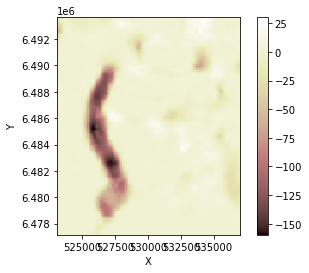

In [14]:
grid = RasterModelGrid(vx_data.shape, xy_of_lower_left = lower_left, xy_spacing = resolution)
vx = grid.add_field('velocity_x', -np.flip(vy_data, axis = [0]), at = 'node')
vy = grid.add_field('velocity_y', np.flip(vx_data, axis = 0), at = 'node')
imshow_grid(grid, vy)

In [20]:
grid = RasterModelGrid(h_data.shape)
h = grid.add_field('ice_thickness', h_data, at = 'node')
vx = grid.add_field('velocity_x', vy_data, at = 'node')
vy = grid.add_field('velocity_y', vx_data, at = 'node')

ValueError: unable to reshape array to field size (94135 != 90475)

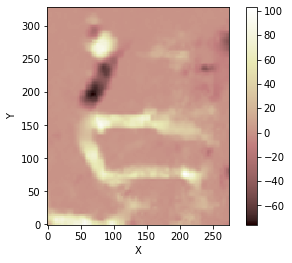

In [17]:
imshow_grid(grid, vx)

In [3]:
with rio.open(h_file) as fh:
    h_data = np.flip(fh.read(1), axis = 0)

with rio.open(vy_file) as fy:
    vy_data = np.flip(-fy.read(1), axis = 0)

with rio.open(vx_file) as fx:
    vx_data = np.flip(fx.read(1), axis = 0)

In [4]:
grid = RasterModelGrid((329, 275))

In [112]:
# vx and vy are intentionally swapped
h = grid.add_field('ice_h', h_data, at = 'node', copy = True, clobber = True, nodata_value = -99999)
vx = grid.add_field('velocity_x', vy_data, at = 'node', copy = True, clobber = True)
vy = grid.add_field('velocity_y', vx_data, at = 'node', copy = True, clobber = True)
vv = grid.add_field('velocity', np.sqrt(vx**2 + vy**2), at = 'node', clobber = True)

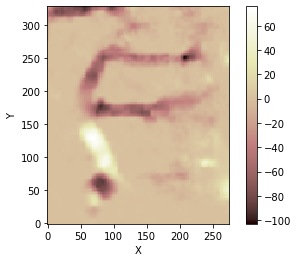

In [142]:
imshow_grid(grid, vx)

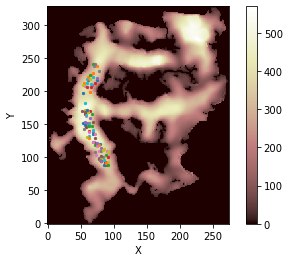

In [143]:
starting_region = np.where(vv > 120)[0]
n_pts = 100
sample = np.random.choice(starting_region, size = n_pts, replace = False)

imshow_grid(grid, h)
for i in sample:
    x = grid.node_x[i]
    y = grid.node_y[i]
    plt.scatter(x, y, s = 5)
plt.show()

In [284]:
nt = 7000
flowline = {'time_step': np.array([t for t in range(nt)]),
            'velocity': np.empty(nt),
            'ice_h': np.empty(nt),
            'nodes': np.empty(nt),
            'distance': np.empty(nt)}

node_id = np.random.choice(starting_region, size = 1)
x_loc = grid.node_x[node_id]
y_loc = grid.node_y[node_id]

o_x = grid.node_x[node_id]
o_y = grid.node_y[node_id]

dt = 0.025
scale = 1 / 50
y_break = 10

for t in range(nt):
    flowline['velocity'][t] = vv[node_id]
    flowline['ice_h'][t] = h[node_id]
    flowline['nodes'][t] = node_id
    flowline['distance'][t] = np.sqrt((x_loc - o_x)**2 + (y_loc - o_y)**2)
    
    x_loc += vx[node_id] * scale * dt
    y_loc += vy[node_id] * scale * dt
    
    node_id = find_nearest_node(grid, (x_loc, y_loc))
    
    if y_loc < y_break:
        break

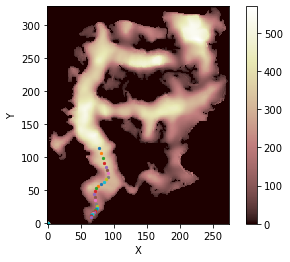

In [285]:
imshow_grid(grid, h)
for i in range(len(flowline['nodes'])):
    idx = int(flowline['nodes'][i])
    
    if i % 100 == 0:
        plt.scatter(grid.node_x[idx], grid.node_y[idx], s = 5)
        
plt.show()

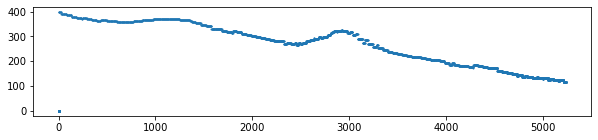

In [286]:
fig, ax = plt.subplots(figsize = (10, 2))

plt.scatter(flowline['distance'] * 50, flowline['ice_h'], s = 1)
plt.show()